In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.stats import norm
import time

# Lettura dati

In [133]:
filename_in = './IRM-MarketData31Oct2019.xlsx'

In [134]:
# Load Volatility Surface Data
vol_surf_sheet = 'VolSurf_D_Input'
input_data = pd.read_excel(filename_in, sheet_name=vol_surf_sheet, header=None)
tenor = input_data.iloc[0, 0]
expiry = input_data.iloc[1:, 0].values
n_exp = len(expiry)
n_strike = input_data.shape[1] - 1
atm_strike_index = input_data.columns[(input_data.iloc[0] == 0).values][0]
atm_vol = input_data.iloc[1:, atm_strike_index].values
vola_surf = input_data.iloc[1:, 1:].values.copy()

In [135]:
# Shift and adjust the volatility surface
vola_shift = np.hstack((vola_surf[:, :atm_strike_index-1], vola_surf[:, atm_strike_index:]))
vola_surf[:, :atm_strike_index-1] += np.tile(atm_vol[:, np.newaxis], (1, atm_strike_index-1))
size_x = vola_surf[:, atm_strike_index:].shape[1]
vola_surf[:, atm_strike_index:] += np.tile(atm_vol[:, np.newaxis], (1, size_x))
strike_shift = input_data.iloc[0, 1:].values
vola_surf /= 100

In [136]:
# Load Displacement Data
displacement_sheet = 'Displacement_Input'
input_data_d = pd.read_excel(filename_in, sheet_name=displacement_sheet, header=None)
d = input_data_d.iloc[1:, 1:].values
tenor_d = input_data_d.iloc[0, 1:].values
expiry_d = input_data_d.iloc[1:, 0].values
index_d = np.where(tenor_d == tenor)[0][0]
d_vector = d[:, index_d]


In [137]:
# Load Discounting Curve Data
input_data_d = pd.read_excel(filename_in, sheet_name='IR_Curve_Discounting', header=None)
input_data_d = input_data_d.iloc[2:]
zc_d_in = np.column_stack((input_data_d.iloc[:, 0] / 365, input_data_d.iloc[:, 1]))

In [138]:

# Load Forwarding Curve Data
zc_d_in_2 = pd.read_excel(filename_in, sheet_name='IR_Curve_Forwarding', header=None)
zc_d_in_2 = zc_d_in_2.iloc[2:]
zc_f_in = np.column_stack((zc_d_in_2.iloc[:, 4] / 365, zc_d_in_2.iloc[:, 5]))

In [139]:
# Load Forwarding Curve Data for 3M
zc_f_3m_in = np.column_stack((zc_d_in_2.iloc[:, 2] / 365, zc_d_in_2.iloc[:, 3]))
zc_f_3m_in = np.column_stack((pd.to_numeric(zc_d_in_2.iloc[:, 2], errors='coerce') / 365, pd.to_numeric(zc_d_in_2.iloc[:, 3], errors='coerce')))
index = np.isnan(zc_f_3m_in[:, 0])
zc_f_3m_in = zc_f_3m_in[~index]

zc_d_in_2 = np.asarray(zc_d_in_2)
zc_f_in = np.asarray(zc_f_in)

In [140]:
# Unique curve pillars
# curve_pillars = np.unique(np.concatenate([zc_d_in[:, 0], zc_f_in[:, 0]]))
# curve_pillars = np.unique(np.concatenate([zc_d_in.iloc[:, 0].values, zc_f_in.iloc[:, 0].values]))
curve_pillars = np.unique(np.concatenate([zc_d_in[:, 0], zc_f_in[:, 0]]))
curve_pillars = np.insert(curve_pillars, 0, 0)

In [141]:
# Interpolation
zc_f_in = zc_f_in.astype(float)
curve_pillars = curve_pillars.astype(float)
zc_f = interp1d(np.concatenate([[0], zc_f_in[:, 0], [100]]), np.concatenate([[zc_f_in[0, 1]], zc_f_in[:, 1], [zc_f_in[-1, 1]]]), fill_value='extrapolate')(curve_pillars)

zc_d = interp1d(np.concatenate([[0], zc_d_in[:, 0], [100]]), np.concatenate([[zc_d_in[0, 1]], zc_d_in[:, 1], [zc_d_in[-1, 1]]]), fill_value='extrapolate')(curve_pillars)

zc_f_3m = interp1d(np.concatenate([[0], zc_f_3m_in[:, 0], [100]]), np.concatenate([[zc_f_3m_in[0, 1]], zc_f_3m_in[:, 1], [zc_f_3m_in[-1, 1]]]), fill_value='extrapolate')(curve_pillars)

In [142]:
# Initialization of SABR parameters and calibration surface
alpha_sabr = np.zeros(n_exp)
beta_sabr = np.zeros(n_exp)
rho_sabr = np.zeros(n_exp)
nu_sabr = np.zeros(n_exp)
calib_surf = np.zeros((n_exp, n_strike))

# Strikes, Annuity, and Par Swap Rates initialization
strikes_t = np.zeros((n_exp, n_strike))
annuity = np.zeros(n_exp)
par_swap = np.zeros(n_exp)

In [157]:
# alpha=0.03
# beta=0.2
# rho=-0.2
# nu=0.3
alpha=0.023
beta=0.5
rho=-0.1
nu=0.6
sabrparam=[alpha,beta,rho,nu]
shift = 0.00


is_fixed_alpha=0
is_fixed_beta=1
is_fixed_rho=0
is_fixed_nu=0

# Shifted SABR

$$
\sigma_{\text{SABR}}(F, K, T, \alpha, \beta, \rho, \nu, \text{shift}) = \frac{\alpha}{(F + \text{shift}) (K + \text{shift})^{\frac{1-\beta}{2}}} \left( \frac{z}{x(z)} \right) \left( 1 + \left[ \frac{(1-\beta)^2 \alpha^2}{24 (F + \text{shift}) (K + \text{shift})^{\frac{1-\beta}{2}}} + \frac{\rho \beta \nu \alpha}{4 (F + \text{shift}) (K + \text{shift})^{\frac{1-\beta}{2}}} + \frac{(2-3\rho^2) \nu^2}{24} \right] T \right)
$$

dove:
- $z = \frac{\nu}{\alpha} \left[ (F + \text{shift}) (K + \text{shift}) \right]^{\frac{1-\beta}{2}} \ln\left(\frac{F + \text{shift}}{K + \text{shift}}\right)$
- $x(z) = \ln\left(\frac{\sqrt{1 - 2 \rho z + z^2} + z - \rho}{1 - \rho}\right)$

In [158]:
def sabr_volatility(F, K, T, alpha, beta, rho, nu, shift):
    epsilon = 1e-8  # Numero piccolo giusto per evitare  divisioni per zero
    F += shift  # Shift the forward rate
    K += shift  # Shift the strike price

    # Handle the special case when F is equal to K to avoid division by zero
    if F == K:
        z = 0  # When F is equal to K, z should be 0 to avoid division by zero in x_z
        x_z = 0  # x(z) should also be 0 in this case
    else:
        # Calculate z, ensuring the argument inside the logarithm is positive
        z = (nu / alpha) * (F * K) ** ((1 - beta) / 2) * np.log(F / K)

        # Calculate x(z), ensuring the argument inside the square root and logarithm is valid
        sqrt_term = 1 - 2 * rho * z + z**2
        # Protect against negative values under the square root
        sqrt_term = max(sqrt_term, 0)

        # Protect against division by zero in x(z) calculation
        log_term = (np.sqrt(sqrt_term) + z - rho) / (1 - rho + epsilon)
        # Protect against log of zero or negative
        log_term = max(log_term, epsilon)

        x_z = np.log(log_term)
        

    A = (1 + (alpha**2 * (1 - beta)**2 / (24 * (F * K)**((1 - beta) + epsilon)) +
          rho * beta * nu * alpha / (4 * (F * K)**((1 - beta) / 2) + epsilon) +
          (2 - 3 * rho**2) * nu**2 / 24) * T)
    
    # Handle the special ATM case separately to avoid division by zero
    if F != K:
        volatility = (alpha / ((F * K) ** ((1 - beta) / 2) * (1 + ((1 - beta) ** 2 / 24) * np.log(F / K) ** 2 + ((1 - beta) ** 4 / 1920) * np.log(F / K) ** 4))) * (z / x_z) * A
    else:
        volatility = alpha / (F ** (1 - beta)) * A

    return volatility

## Calibrazione 

$\text{cost}(\alpha, \beta, \rho, \nu, f) = \sum_{i=1}^{N} \left( \sigma_{\text{market}}(F_i, K_i, T_i) - \sigma_{\text{SABR}}(F_i, K_i, T_i, \alpha, \beta, \rho, \nu, f) \right)^2$


In [159]:
def SABR_Calibration(market_vols, strikes, alpha, beta, rho, nu, is_fixed_alpha, is_fixed_beta, is_fixed_rho, is_fixed_nu, F, T, shift):
    initial_params = [alpha, beta, rho, nu]
    fixed_params_flags = [is_fixed_alpha, is_fixed_beta, is_fixed_rho, is_fixed_nu]

    variable_params_bounds = []
    if not is_fixed_alpha:
        variable_params_bounds.append((0, None))  # alpha bound
    if not is_fixed_beta:
        variable_params_bounds.append((0, 1))  # beta bound
    if not is_fixed_rho:
        variable_params_bounds.append((-1, 1))  # rho bound
    if not is_fixed_nu:
        variable_params_bounds.append((0, None))  # nu bound

    regularization_factors = {'alpha': 0.01, 'beta': 0.01, 'rho': 0.01, 'nu': 0.01}

    # Modify the objective function to include regularization
    def objective(params):
        nonlocal alpha, beta, rho, nu

        # Your existing code to set alpha, beta, rho, nu from params
        
        # Compute the model volatilities
        model_vols = np.array([sabr_volatility(F, K, T, alpha, beta, rho, nu, shift) for K in strikes])
        
        # Calculate the sum of squared errors
        error = np.sum((market_vols - model_vols) ** 2)
        
        # Add regularization terms
        regularization = (regularization_factors['alpha'] * alpha**2 +
                        regularization_factors['beta'] * beta**2 +
                        regularization_factors['rho'] * rho**2 +
                        regularization_factors['nu'] * nu**2)
        
        return error

    # Define which parameters to optimize
    params_to_optimize = [p for p, fixed in zip(initial_params, fixed_params_flags) if not fixed]

    # Perform the optimization
    result = minimize(objective, params_to_optimize, method='L-BFGS-B', bounds=variable_params_bounds)
    # result = minimize(objective, params_to_optimize, method='nelder-mead', bounds=variable_params_bounds)
    # result = minimize(objective, params_to_optimize, method='BFGS', bounds=variable_params_bounds)
    # result = minimize(objective, params_to_optimize, method='SLSQP', bounds=variable_params_bounds)
    # result = least_squares(objective, params_to_optimize)
    
    if result.success:
        # Update the parameters with optimized values
        optimized_params = result.x
        idx = 0
        if not is_fixed_alpha:
            alpha = optimized_params[idx]
            idx += 1
        if not is_fixed_beta:
            beta = optimized_params[idx]
            idx += 1
        if not is_fixed_rho:
            rho = optimized_params[idx]
            idx += 1
        if not is_fixed_nu:
            nu = optimized_params[idx]

        return alpha, beta, rho, nu
    else:
        raise Exception("Calibration failed.")

In [160]:
def SABR_Implied_Vol(params, F, strikes, T, shift):
    alpha, beta, rho, nu = params
    vols = [sabr_volatility(F, K, T, alpha, beta, rho, nu, shift) for K in strikes]
    return vols

In [161]:
for i in range(n_exp):
    # Generate Swap Dates
    start_t = expiry[i]
    pay_t_float = start_t + np.arange(0.5, tenor + 0.5, 0.5)
    pay_t_fix = start_t + np.arange(1, tenor + 1)

    # ZC interpolation - linear on rates
    zc_d_int_fix = interp1d(curve_pillars, zc_d, kind='linear', fill_value='extrapolate')(pay_t_fix)
    zc_d_int_float = interp1d(curve_pillars, zc_d, kind='linear', fill_value='extrapolate')(pay_t_float)
    zc_f_int_float = interp1d(curve_pillars, zc_f, kind='linear', fill_value='extrapolate')(np.insert(pay_t_float, 0, start_t))

    # Compute discount factor
    df_f_int_float = np.exp(-zc_f_int_float * np.insert(pay_t_float, 0, start_t))
    df_d_int_float = np.exp(-zc_d_int_float * pay_t_float)
    df_d_int_fix = np.exp(-zc_d_int_fix * pay_t_fix)

    # Compute par rates
    fwd_libor = (df_f_int_float[:-1] / df_f_int_float[1:] - 1) / 0.5
    float_leg = 0.5 * fwd_libor * df_d_int_float
    annuity[i] = np.sum(df_d_int_fix)

    par_swap[i] = np.sum(float_leg) / annuity[i]
    strikes_t[i, :] = par_swap[i] + strike_shift / 10000

    index_shift = np.where(vola_shift[i, :] == 0)[0]
    index_strike = np.where(strikes_t[i, :] + d_vector[i] < 0.001)[0]

    if len(index_shift) == 0:
        z_shift = index_shift[index_shift < atm_strike_index]
        vola_surf[i, z_shift] = 0
        z_shift = index_shift[index_shift > atm_strike_index]
        vola_surf[i, z_shift + 1] = 0

    if len(index_strike) == 0:
        z_shift = index_strike[index_strike < atm_strike_index]
        vola_surf[i, z_shift] = 0
        z_shift = index_strike[index_strike > atm_strike_index]
        vola_surf[i, z_shift + 1] = 0

    index_vol = np.where(np.abs(vola_surf[i, :]) > 0)[0]
    if len(index_vol) > 3:  # If not, we cannot calibrate
        alpha_out= 0
        beta_out= 0
        rho_out= 0
        nu_out= 0
        
        alpha_out, beta_out, rho_out, nu_out = SABR_Calibration(vola_surf[i, index_vol], 
                                                                 strikes_t[i, index_vol] + d_vector[i], 
                                                                 alpha, beta, rho, nu, 
                                                                 is_fixed_alpha, is_fixed_beta, is_fixed_rho, is_fixed_nu, 
                                                                 par_swap[i] + d_vector[i], start_t, 1)
        
        # Saving the calibration outputs
        alpha_sabr[i], beta_sabr[i], rho_sabr[i], nu_sabr[i] = alpha_out, beta_out, rho_out, nu_out

        # Placeholder for SABR implied volatility calculation - you'll need to implement or provide this function
        index_positive = np.where(strikes_t[i, :] + d_vector[i] > 0)[0]
        
        calib_vol = SABR_Implied_Vol([alpha_out, beta_out, rho_out, nu_out], 
                                     par_swap[i] + d_vector[i], 
                                     strikes_t[i, index_positive] + d_vector[i], start_t, shift)
        # calib_vol = SABR_Implied_Vol([0.0070, 0.2000, 0.2241, 1.0344], 
        #                              par_swap[i] + d_vector[i], 
        #                              strikes_t[i, index_positive] + d_vector[i], start_t, shift)

        calib_surf[i, index_positive] = calib_vol


In [162]:
sabr_tot = np.column_stack((alpha_sabr, beta_sabr, rho_sabr, nu_sabr))

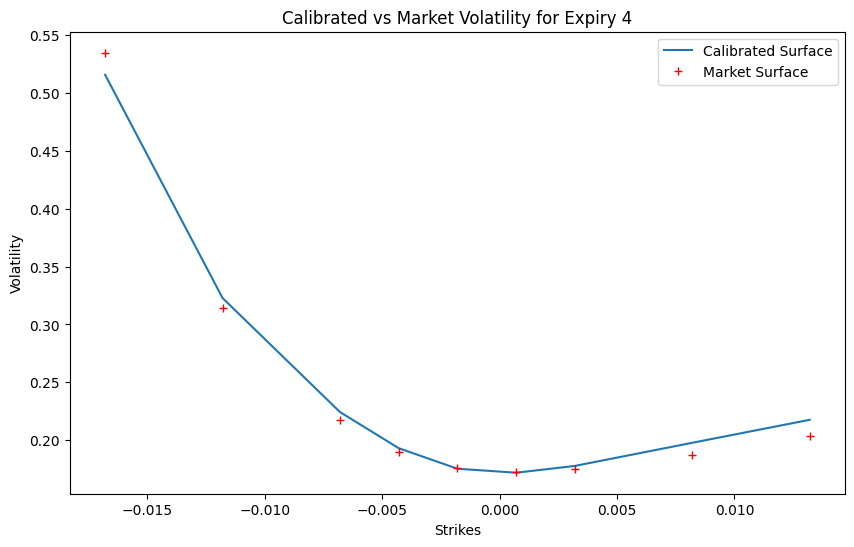

In [163]:
nn = 4
plt.figure(figsize=(10, 6))
plt.plot(strikes_t[nn, :], calib_surf[nn, :], label='Calibrated Surface')
plt.plot(strikes_t[nn, :], vola_surf[nn, :], '+r', label='Market Surface')
plt.xlabel('Strikes')
plt.ylabel('Volatility')
plt.title(f'Calibrated vs Market Volatility for Expiry {nn}')
plt.legend()
plt.show()

# a) 

Confronto tra le volatilità calibrate per ogni scadenza

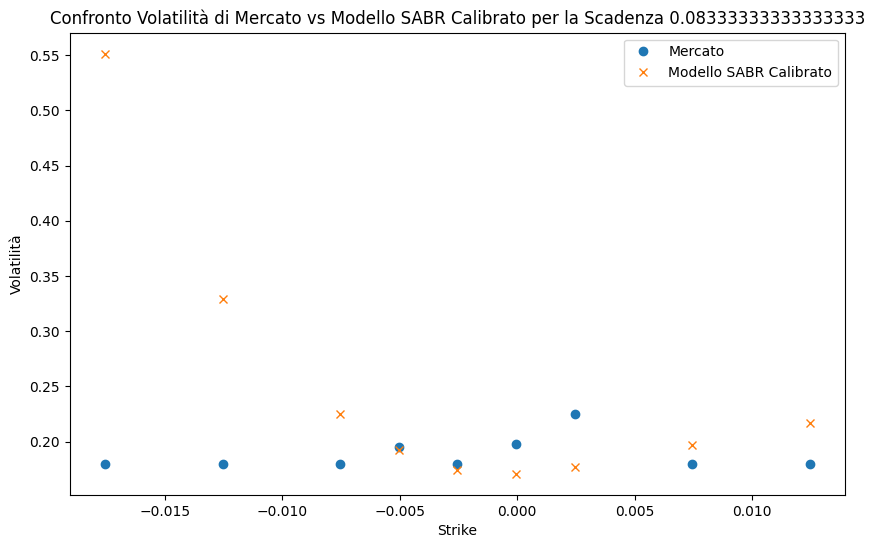

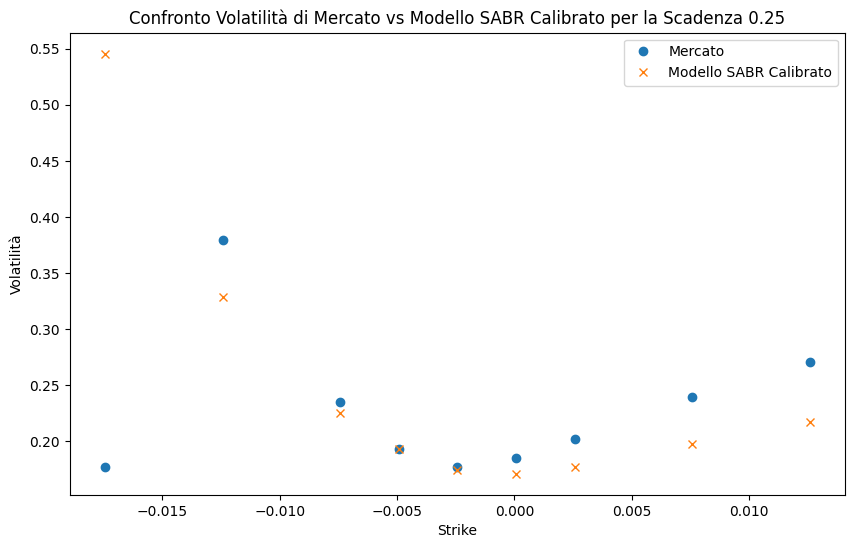

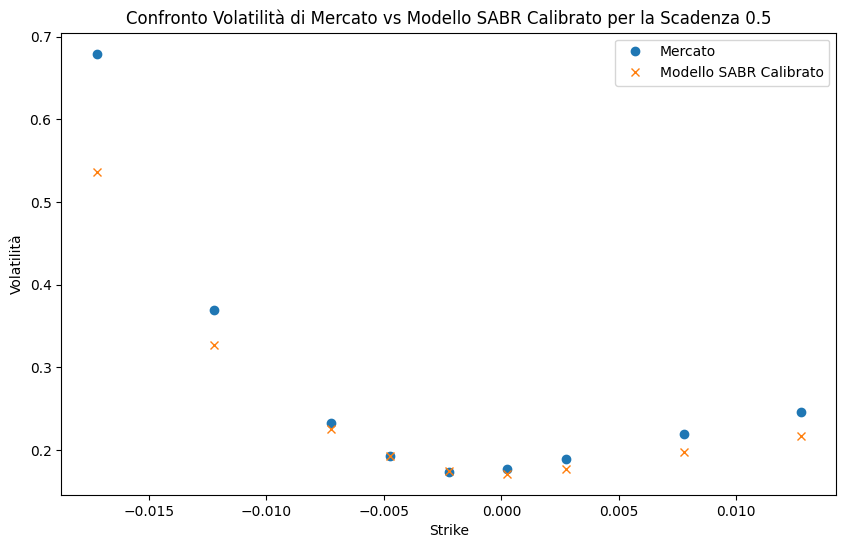

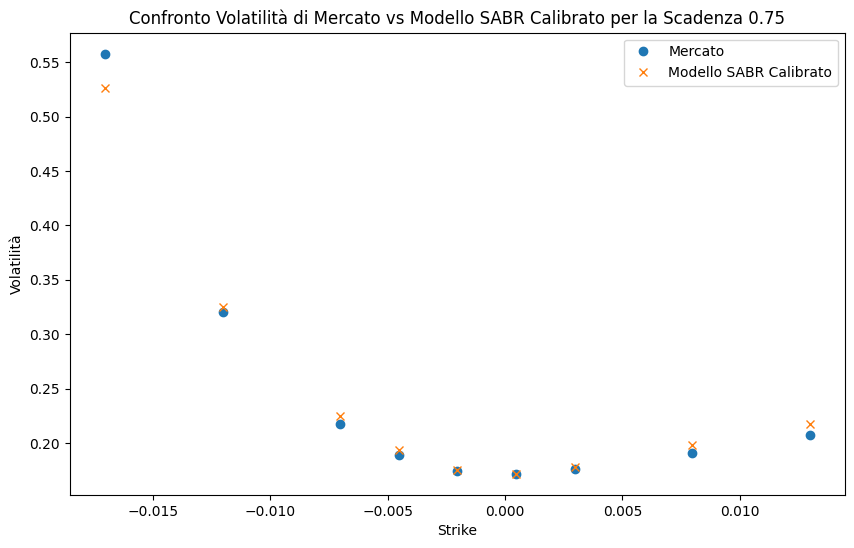

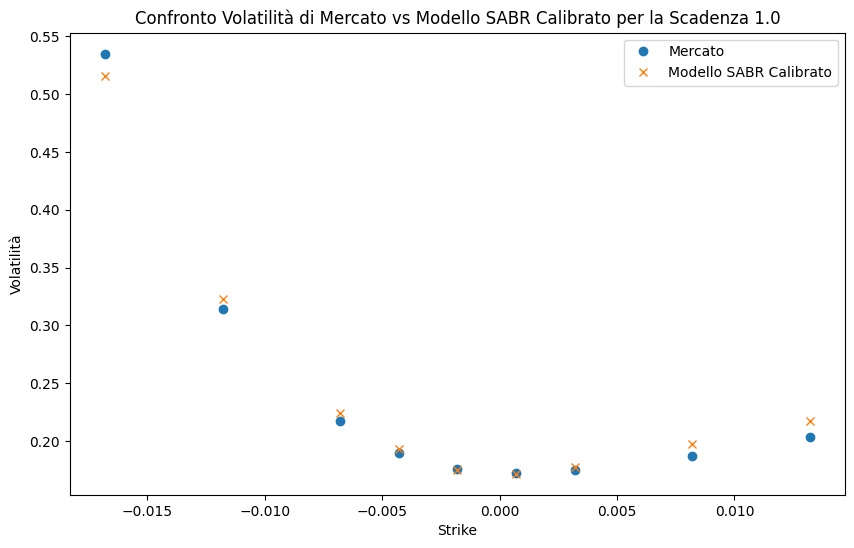

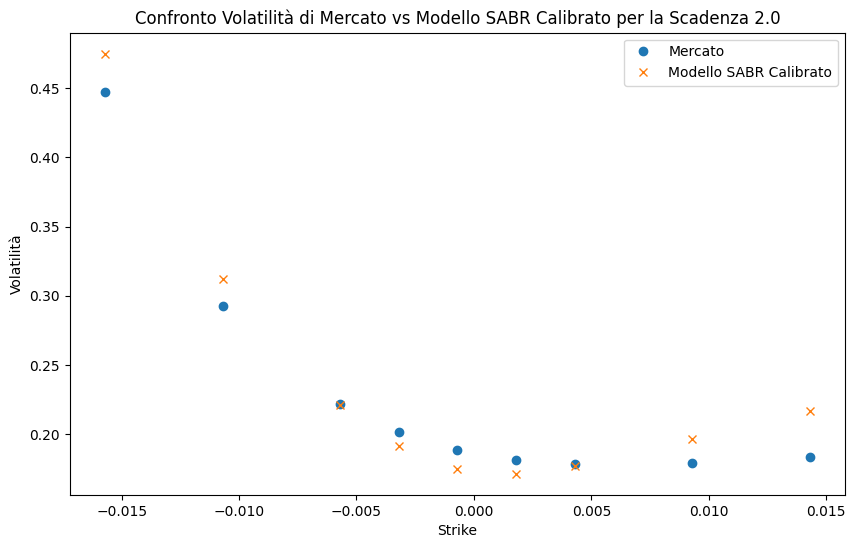

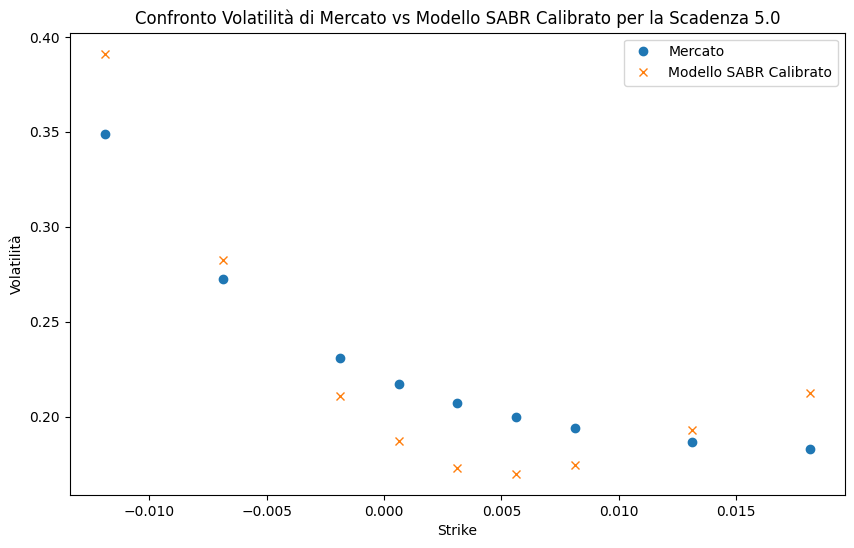

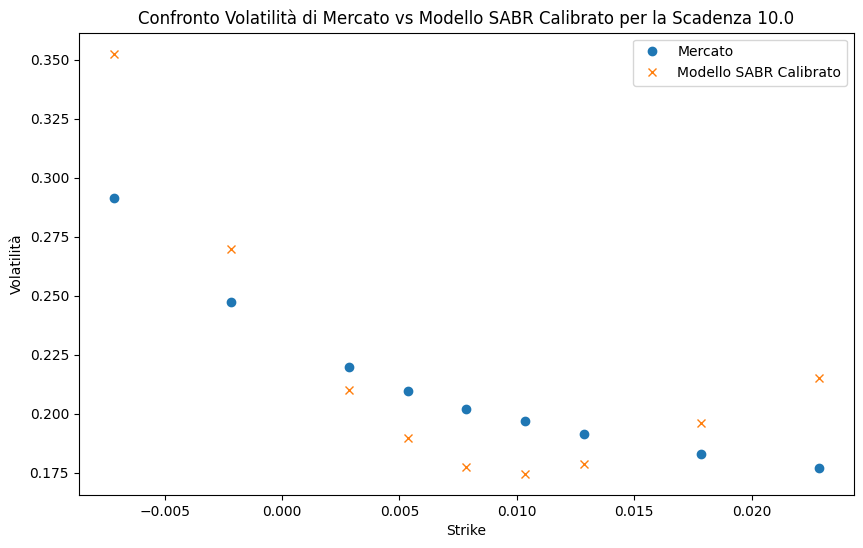

In [177]:
for i, exp in enumerate(expiry):
    plt.figure(figsize=(10, 6))
    plt.plot(strikes_t[i], vola_surf[i], 'o', label='Mercato')
    plt.plot(strikes_t[i], calib_surf[i], 'x', label='Modello SABR Calibrato')
    plt.title(f'Confronto Volatilità di Mercato vs Modello SABR Calibrato per la Scadenza {exp}')
    plt.xlabel('Strike')
    plt.ylabel('Volatilità')
    plt.legend()
    plt.show()


# b) RMSE

$$
\text{Vega}_{\text{SABR}}(F, K, T, \alpha, \beta, \rho, \nu, \text{shift}) = K \cdot \phi(d_1) \cdot \sqrt{T}
$$

dove

- $d_1 = \frac{\ln\left(\frac{F + \text{shift}}{K + \text{shift}}\right) + \frac{1}{2} \alpha^2 T}{\alpha \sqrt{T}}$
- $\phi(d_1)$ è la funzione densità di probabilità della distribuzione normale standard.

In [ ]:
# Funzione per il calcolo di vega del modello SABR per un dato set di parametri e punti di mercato
def sabr_vega(F, K, T, alpha, beta, rho, nu, shift):
    d1 = (np.log((F + shift) / (K + shift)) + 0.5 * alpha**2 * T) / (alpha * np.sqrt(T))
    vega = K * norm.pdf(d1) * np.sqrt(T)
    return vega

$$
\text{Prezzo}_{\text{SABR}}(F, K, T, \alpha, \beta, \rho, \nu, \text{shift}) = (F + \text{shift}) \Phi(d_1) - (K + \text{shift}) \Phi(d_2)
$$

dove

- $d_2 = d_1 - \alpha \sqrt{T}$

- $\Phi è la funzione di distribuzione cumulativa della distribuzione normale standard.

In [ ]:
# Funzione che calcola il prezzo dell'opzione nel modello SABR
def option_price_model(F, K, T, alpha, beta, rho, nu, shift):
    d1 = (np.log((F + shift) / (K + shift)) + 0.5 * alpha**2 * T) / (alpha * np.sqrt(T))
    d2 = d1 - alpha * np.sqrt(T)
    call_price = (F + shift) * norm.cdf(d1) - (K + shift) * norm.cdf(d2)
    return call_price

In [ ]:

# Calcolo della vega per ogni punto della superficie di volatilità
vega_weights = np.array([sabr_vega(par_swap[i], strikes_t[i, j], expiry[i], alpha_sabr[i], beta_sabr[i], rho_sabr[i], nu_sabr[i], d_vector[i])
                         for i in range(len(expiry))  # per ogni scadenza
                         for j in range(strikes_t.shape[1])])  # per ogni strike

# Normalizzazione dei pesi vega
vega_weights /= np.sum(vega_weights)

In [ ]:
market_prices = vola_surf.flatten()  # Prezzi di mercato per ogni punto della superficie di volatilità
model_prices = calib_surf.flatten()  # Prezzi calibrati per ogni punto della superficie di volatilità

$$
\text{RMSE}(p) = \sqrt{\frac{1}{N} \sum_{i=1}^{N} \left( \sigma^{SABR}_i(p) - \sigma^{mkt}_i \right)^2 }
$$

In [185]:
# Calcolo degli errori: differenza tra le volatilità calibrate dal modello e quelle di mercato
errors = model_prices - market_prices

# Calcolo dell'errore quadratico medio (MSE)
mse = np.mean(errors**2)

# Calcolo della radice quadrata dell'MSE per ottenere l'RMSE
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

RMSE: 0.07014231400513413


$$
\text{RMSE}(p) = \sqrt{\frac{1}{N} \sum_{i=1}^{N} \left\{ w_i \left[ \sigma_i^{SABR}(p) - \sigma_i^{mkt} \right] \right\}^2 },
$$

$$
w_i = \frac{\text{Vega}_i}{\sum_{i=1}^{N} \text{Vega}_i},
$$

In [186]:
# Calcolo degli errori ponderati per la vega: differenza tra le volatilità calibrate dal modello e quelle di mercato
weighted_errors = vega_weights * (model_prices - market_prices)**2

# Calcolo dell'errore quadratico medio ponderato (Weighted MSE)
weighted_mse = np.mean(weighted_errors)

# Calcolo della radice quadrata dell'MSE ponderato per ottenere l'RMSE ponderato per la vega
rmse_vega_weighted = np.sqrt(weighted_mse)

print(f"Vega Weighted RMSE: {rmse_vega_weighted}")

Vega Weighted RMSE: 0.003090345610763952


$$
\text{RMSRE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} w_i \left( \frac{\text{Prezzo}_{\text{modello}} + \epsilon}{\text{Prezzo}_{\text{mercato}} + \epsilon} - 1 \right)^2 }
$$

dove

- $w_i = \frac{\text{Vega}_{\text{SABR}, i}}{\sum_{j=1}^{N} \text{Vega}_{\text{SABR}, j}}$
- $\epsilon$ è un piccolo valore aggiunto per stabilizzare la formula quando si lavora con prezzi molto bassi

In [183]:
epsilon = 1e-4


rmsre = np.sqrt(np.mean(vega_weights * ((model_prices + epsilon) / (market_prices + epsilon) - 1)**2))

print(f"RMSRE: {rmsre}")

RMSRE: 0.015269499033886342


In [206]:
data = [['RMSE', rmse, '{:.2f}%'.format(rmse*100)],
        ['Vega Weighted RMSE', rmse_vega_weighted, '{:.2f}%'.format(rmse_vega_weighted*100)],
        ['RMSRE', rmsre, '{:.2f}%'.format(rmsre*100)]] 
df = pd.DataFrame(data, columns=['Metodo', 'Risultato', 'Risultato %'])
df = df.style.set_caption('Calibration test')
df


,Metodo,Risultato,Risultato %
0,RMSE,0.070142,7.01%
1,Vega Weighted RMSE,0.003090,0.31%
2,RMSRE,0.015269,1.53%


# C)

In [210]:
def objective_function(params):
    alpha, beta, rho, nu = params
    error = np.sum((model_prices - market_prices) ** 2)
    return np.sqrt(error / len(market_prices))

# Imposta i parametri iniziali per la calibrazione
initial_params = [0.03, 0.5, 0.1, 0.3]

# Lista dei metodi di ottimizzazione da testare
methods = ['Nelder-Mead', 'BFGS', 'L-BFGS-B', 'TNC', 'SLSQP']

# Dizionario per raccogliere i risultati dell'ottimizzazione
optimization_results = {}

# calibrazione per ogni metodo
for method in methods:
    start_time = time.time()  # Tempo di inizio
    result = minimize(objective_function, initial_params, method=method)
    end_time = time.time()  # Tempo di fine
    optimization_results[method] = {
        'params': result.x,
        'objective_value': result.fun,
        'success': result.success,
        'time_taken': end_time - start_time
    }


In [215]:
for method, results in optimization_results.items():
    print(f"Metodo: {method}")
    print(f"Ottimizzazione riuscita: {results['success']}")
    print(f"Tempo impiegato: {results['time_taken']} secondi")
    print("-" * 50)

Metodo: Nelder-Mead
Ottimizzazione riuscita: True
Tempo impiegato: 0.003537893295288086 secondi
--------------------------------------------------
Metodo: BFGS
Ottimizzazione riuscita: True
Tempo impiegato: 0.003240823745727539 secondi
--------------------------------------------------
Metodo: L-BFGS-B
Ottimizzazione riuscita: True
Tempo impiegato: 0.0013608932495117188 secondi
--------------------------------------------------
Metodo: TNC
Ottimizzazione riuscita: True
Tempo impiegato: 0.002225160598754883 secondi
--------------------------------------------------
Metodo: SLSQP
Ottimizzazione riuscita: True
Tempo impiegato: 0.0012669563293457031 secondi
--------------------------------------------------


Si sono utilizzati i seguienti metodi e le conclusioni sono:
1. **Nelder-Mead**:
   - È un metodo di ottimizzazione diretta che non richiede il calcolo di gradienti.
   - Usa un simplesso di vertici che si evolve ad ogni iterazione.
   - Adatto per funzioni non differenziabili e problemi di ottimizzazione di piccole dimensioni.

2. **BFGS (Broyden–Fletcher–Goldfarb–Shanno)**:
   - È un algoritmo quasi-Newtoniano che usa gradienti per trovare il minimo di una funzione differenziabile.
   - Approssima la matrice Hessiana della funzione obiettivo.
   - Richiede più memoria rispetto ai metodi che non conservano la matrice Hessiana approssimata.

3. **L-BFGS-B (Limited Memory BFGS with Bounds)**:
   - Versione del BFGS che usa meno memoria, adatta per problemi di grande dimensione.
   - Permette di specificare limiti superiori e inferiori per i parametri.
   - È un metodo di ottimizzazione non lineare.

4. **TNC (Truncated Newton)**:
   - È un algoritmo di ottimizzazione con vincoli che usa un approccio Newton troncato.
   - Calcola il gradiente e usa una approssimazione del Newton per trovare la direzione di ricerca.
   - È efficace per problemi con un gran numero di variabili e per funzioni con derivata seconda sparsa o costosa da calcolare.

5. **SLSQP (Sequential Least Squares Programming)**:
   - È un algoritmo di ottimizzazione per problemi con vincoli lineari e non lineari.
   - Risolve una serie di sottoproblemi di minimizzazione dei quadrati ogni volta che si muove verso la soluzione.

# d)

In [220]:
# Lista di valori di beta da testare
beta_values = np.linspace(0, 1, 11) # array di valori che vanno da 0 a 1 suddivisi in modo uniforme, con un totale di 11 valori da testare per Beta


beta_tests = []
rmse_results = []


for beta in beta_values:
    rmse_per_expiry = []
    
    for i in range(n_exp):
        # Estrai il tasso forward e lo shift per la scadenza corrente
        F_i = par_swap[i]
        shift_i = d_vector[i]
        
        # Estrai gli strike e le volatilità di mercato per la scadenza corrente
        strikes_i = strikes_t[i, :]
        market_vols_i = vola_surf[i, :]

        # Calibrazione del modello SABR con beta fisso per la scadenza corrente
        alpha_calib, _, rho_calib, nu_calib = SABR_Calibration(
            market_vols=market_vols_i,
            strikes=strikes_i,
            alpha=alpha,
            beta=beta,
            rho=rho,
            nu=nu,
            is_fixed_alpha=False,
            is_fixed_beta=True,
            is_fixed_rho=False,
            is_fixed_nu=False,
            F=F_i,
            T=expiry[i],
            shift=shift_i
        )

        # Calcola le volatilità implicite SABR con i parametri calibrati
        model_vols_i = SABR_Implied_Vol(
            params=[alpha_calib, beta, rho_calib, nu_calib],
            F=F_i,
            strikes=strikes_i,
            T=expiry[i],
            shift=shift_i
        )

        # Calcola RMSE per la scadenza corrente
        rmse_i = np.sqrt(np.mean((market_vols_i - np.array(model_vols_i))**2))
        rmse_per_expiry.append(rmse_i)

    # Calcola la media degli RMSE su tutte le scadenze
    rmse_avg = np.mean(rmse_per_expiry)
    rmse_results.append(rmse_avg)
    beta_tests.append(beta)


Il grafico mostra come il valore di RMSE medio varia in relazione a diversi valori fissati del parametro $\beta$ durante la calibrazione del modello SABR.Si può dire che:

1. Il RMSE medio inizia ad un valore elevato quando $\beta$ è vicino a 0, poi diminuisce rapidamente man mano che $\beta$ aumenta. Questo suggerisce che valori molto bassi di $\beta$ non sono ideali per la calibrazione.

2.  Man mano che $\beta$ si avvicina a 0.4, la curva del RMSE medio si appiattisce. Questo indica che i valori di $\beta$ in questo intervallo non hanno un impatto significativo sull'errore di calibrazione, suggerendo un possibile intervallo ottimale per $\beta$.

3. Per valori di $\beta$ superiori a 0.4, il RMSE medio sembra stabilizzarsi intorno a un valore basso, suggerendo che variazioni ulteriori di $\beta$ non migliorano significativamente la calibrazione.

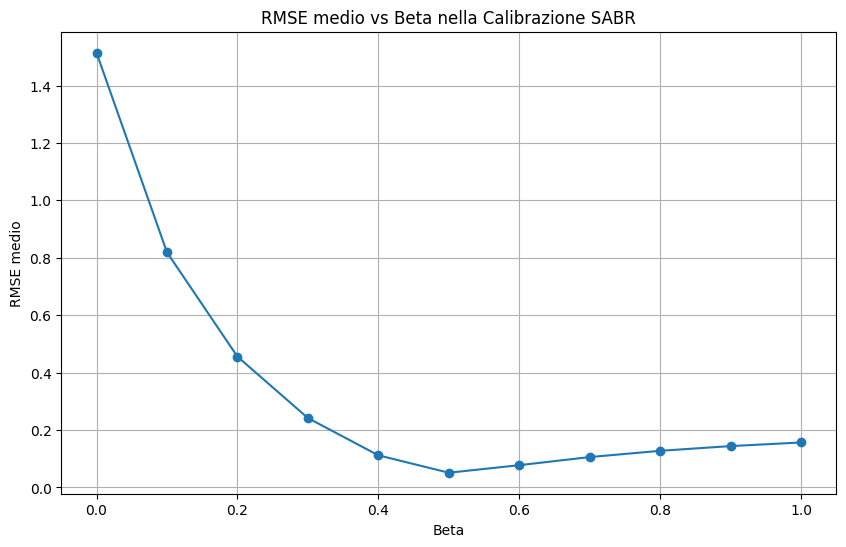

In [221]:
# Grafico RMSE medio vs Beta
plt.figure(figsize=(10, 6))
plt.plot(beta_tests, rmse_results, marker='o')
plt.title('RMSE medio vs Beta nella Calibrazione SABR')
plt.xlabel('Beta')
plt.ylabel('RMSE medio')
plt.grid(True)
plt.show()